In [125]:
import numpy as np 
import pandas as pd
from hmmlearn import hmm

from matplotlib import pyplot as plt
import seaborn as sbn
from matplotlib.patches import Ellipse

import umap

import pickle as pkl

import networkx as nx

# Overview 


HMM using [this](https://hmmlearn.readthedocs.io/en/latest/) package. 

In [2]:
with open('../data/H190923.pkl', 'rb') as f: 
    data = pkl.load(f)
data.head()

,track_index,erk_time(h)=0.0,erk_time(h)=0.2,erk_time(h)=0.5,erk_time(h)=0.8,erk_time(h)=1.0,erk_time(h)=1.2,erk_time(h)=1.5,erk_time(h)=1.8,erk_time(h)=2.0,...,akt_time(h)=13.5,akt_time(h)=13.8,akt_site,akt_median,conc_nm,inhibitor,cell_line,control_OD,optical_density,cell_viab
0,78_1000101697_k562_erk_akt__untreated,0.666206,0.583154,0.464076,0.401721,0.574265,0.628919,0.533323,0.639510,0.808772,...,0.498220,0.523217,78,0.496346,0.0,none,k562,NaN,NaN,1.0
1,77_1000098381_k562_erk_akt__untreated,0.646522,0.419623,0.636420,0.608784,0.593370,0.594475,0.764531,0.781966,0.703256,...,0.630918,0.623906,77,0.503596,0.0,none,k562,NaN,NaN,1.0
2,4_1000007026_k562_erk_akt__untreated,0.731499,0.644271,0.565533,0.405811,0.538459,0.716891,0.771548,0.708265,0.789968,...,0.835404,0.626950,4,0.642910,0.0,none,k562,NaN,NaN,1.0
3,2_1000002957_k562_erk_akt__untreated,0.860727,0.690160,0.633814,0.886553,0.915976,0.856283,0.759563,0.927312,0.948254,...,0.749850,0.384942,2,0.541348,0.0,none,k562,NaN,NaN,1.0
4,82_1000111191_k562_erk_akt__untreated,0.547424,0.521789,0.448863,0.573173,0.504300,0.525133,0.493384,0.638652,0.621023,...,0.684539,0.720796,82,0.609912,0.0,none,k562,NaN,NaN,1.0


In [371]:
def form_data(df): 
    # https://hmmlearn.readthedocs.io/en/latest/tutorial.html#multiple-sequences
    X = np.concatenate((df[df.attrs['clover_selector']].values.reshape(-1, len(df.attrs['clover_selector']), 1), 
                        df[df.attrs['mscarlet_selector']].values.reshape(-1, len(df.attrs['clover_selector']), 1)), 
                       axis=2)
    
    _lens = [X.shape[1]]*X.shape[0]
    X = X.reshape((-1, 2))
    
    
    
    print('shape:', X.shape)
    return X, _lens

In [373]:
# https://hmmlearn.readthedocs.io/en/latest/tutorial.html#multiple-sequences
X, _lens = form_data(data)

shape: (45696, 2)


# Config. Parameters 

In [393]:
nstates = 15
niter   = 10

In [394]:
def get_HMM(X, lengths, nstates, niter, means=None): 
    
    if means is not None: 
        remodel = hmm.GaussianHMM(n_components=nstates, covariance_type="full", n_iter=niter, init_params='stc')
        remodel.means_ = means
    else: 
        remodel = hmm.GaussianHMM(n_components=nstates, covariance_type="full", n_iter=niter, init_params='stc')

    # train 
    remodel.fit(X, lengths)
    print('model converged:', remodel.monitor_.converged)

    return remodel 

In [395]:
# init model
remodel = get_HMM(X, _lens, nstates, niter)

# get states 
Z2 = remodel.predict(X)

model converged: True


In [396]:
# reshape to original observations 
z2 = Z2.reshape((-1, len(data.attrs['clover_selector'])))
z2.shape

(816, 56)

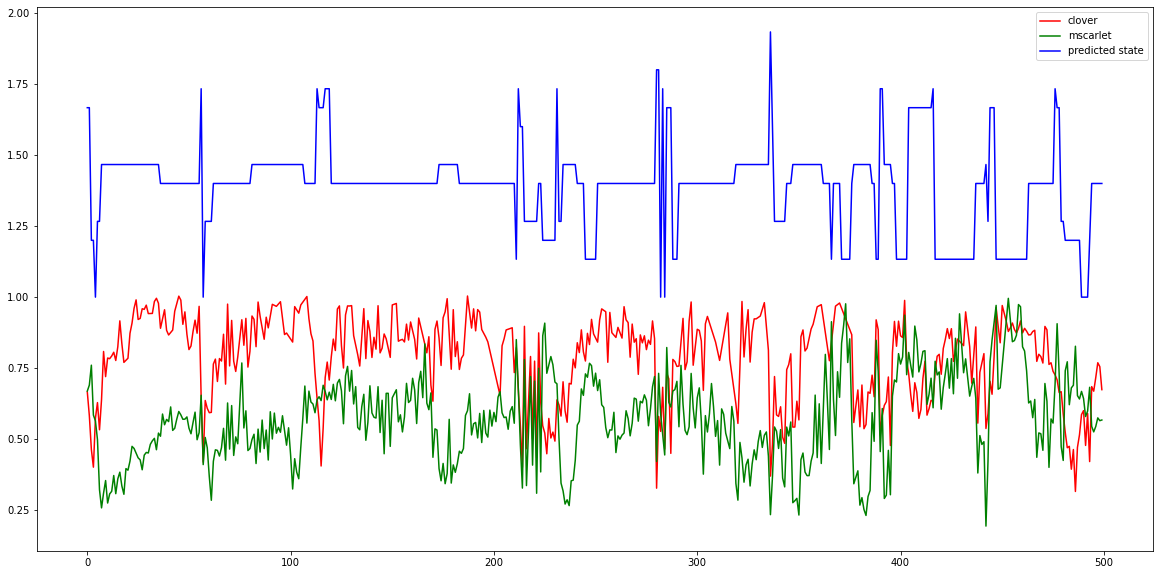

In [397]:
plt.figure(figsize=(20,10))
_n = 500
plt.plot(X[:_n, 0], 'r', label='clover')
plt.plot(X[:_n, 1], 'g', label='mscarlet')
plt.plot(Z2[:_n]/nstates + 1, 'b', label='predicted state')
plt.legend()

plt.show()

In [398]:
# create wide dataframe with track labesl 
res = pd.DataFrame(z2, columns=[float(x.split('=')[-1]) for x in data.attrs['clover_selector']])
res = res.assign(label=data.track_index)

# unstack time - long data
res = res.set_index('label').unstack().reset_index().rename({'level_0':'time', 0:'state'}, axis=1)
res.head()

,time,label,state
0,0.0,78_1000101697_k562_erk_akt__untreated,10
1,0.0,77_1000098381_k562_erk_akt__untreated,11
2,0.0,4_1000007026_k562_erk_akt__untreated,6
3,0.0,2_1000002957_k562_erk_akt__untreated,6
4,0.0,82_1000111191_k562_erk_akt__untreated,3


In [399]:
# count the # time points spent in each sate - for each time series (cell)
out = res.groupby(['label','state']).count().rename({'time':'count'},axis=1).reset_index().set_index('label').pivot(columns='state', values='count').reset_index()

# if a cell never occupies a state, then it is listed as na  -replace these as 0
out = out.fillna(0)

# assign treatments 
out = out.assign(cell__treatment= [x.split('_', 2)[-1] for x in out.label])

# rename states for convenience 
out = out.rename({x:f'state_{x}' for x in out.columns[1:-1]}, axis=1)

# init state_selector to grab relevant col later 
state_sel = out.columns[1:-1]

# merge cell_viab 
out = out.merge(data[['track_index', 'cell_viab']], left_on='label', right_on='track_index', how='left')
out.head()

,label,state_0,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,state_10,state_11,state_12,state_13,state_14,cell__treatment,track_index,cell_viab
0,100_1000161896_k562_erk_akt__5nm_dasatinib,0.0,0.0,14.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,16.0,12.0,0.0,8.0,0.0,k562_erk_akt__5nm_dasatinib,100_1000161896_k562_erk_akt__5nm_dasatinib,1.0
1,100_1000162187_k562_erk_akt__5nm_dasatinib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,k562_erk_akt__5nm_dasatinib,100_1000162187_k562_erk_akt__5nm_dasatinib,1.0
2,100_1000162922_k562_erk_akt__5nm_dasatinib,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,k562_erk_akt__5nm_dasatinib,100_1000162922_k562_erk_akt__5nm_dasatinib,1.0
3,100_1000163162_k562_erk_akt__5nm_dasatinib,2.0,1.0,0.0,1.0,3.0,11.0,0.0,0.0,0.0,1.0,0.0,3.0,9.0,25.0,0.0,k562_erk_akt__5nm_dasatinib,100_1000163162_k562_erk_akt__5nm_dasatinib,1.0
4,100_1000163479_k562_erk_akt__5nm_dasatinib,7.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,3.0,0.0,0.0,0.0,k562_erk_akt__5nm_dasatinib,100_1000163479_k562_erk_akt__5nm_dasatinib,1.0


In [400]:
# make sure the counts for each state sum to the # time points ... 
out[state_sel].sum(axis=1).unique()

array([56.])

In [401]:
# calc total number of time series observations in each treatment group 
tot = out.groupby(['cell__treatment'])['label'].count().reset_index()
tot = tot.assign(label=lambda x: x.label*len(data.attrs['clover_selector'])) # account number of time points 

# calc total amount of time spent in each state within each treatment group 
cnts = out.groupby('cell__treatment').sum().reset_index()

# normalize 
norm_cnts = pd.DataFrame((cnts[state_sel].values.T/tot.label.values).T, columns=state_sel).assign(cell__treatment=cnts.cell__treatment)

In [402]:
# double check we calculated our probabilites properly 
norm_cnts[state_sel].sum(axis=1)

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float64

In [403]:
viz = norm_cnts.set_index('cell__treatment').unstack().reset_index().rename({0:'prob'}, axis=1)
viz.head()

,state,cell__treatment,prob
0,state_0,k562_erk_akt__0.625nm_dasatinib,0.059851
1,state_0,k562_erk_akt__1.25nm_dasatinib,0.066050
2,state_0,k562_erk_akt__1000nm_dasatinib,0.093210
3,state_0,k562_erk_akt__100nm_dasatinib,0.078710
4,state_0,k562_erk_akt__10nm_dasatinib,0.073543


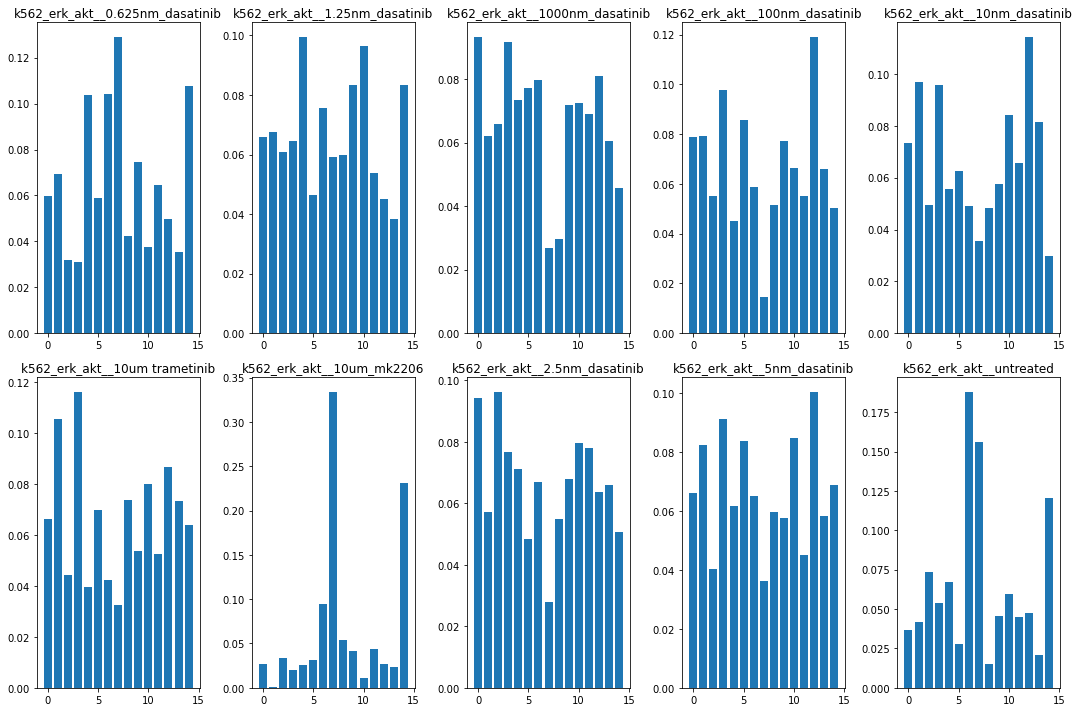

In [404]:
f, axes = plt.subplots(2,5, figsize=(15,10))
for i, row in norm_cnts.iterrows():
    x = row[state_sel].values
    axes.flat[i].bar(x=range(len(x)), height=x, label=row['cell__treatment'])
    axes.flat[i].set_title(row['cell__treatment'])
    
plt.tight_layout()
plt.show()

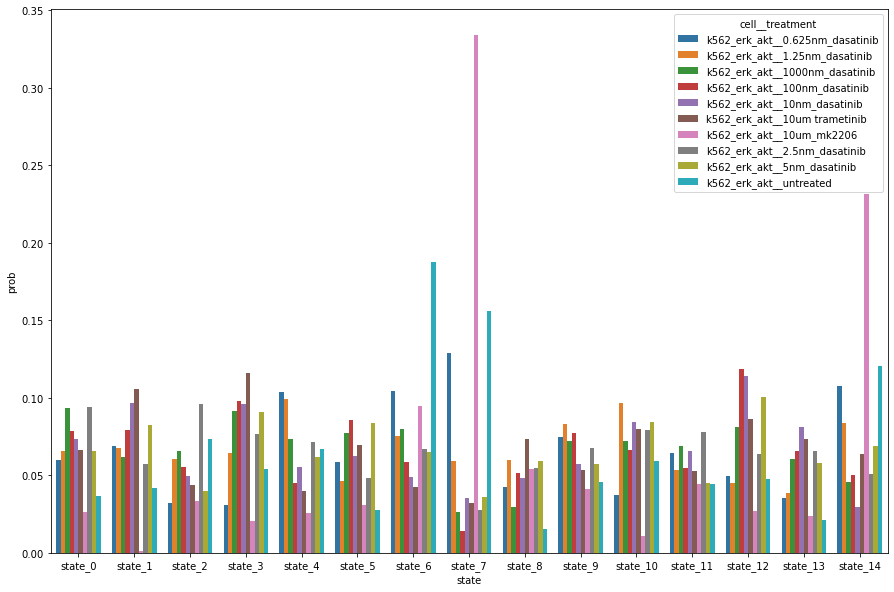

In [405]:
plt.figure(figsize=(15,10))
sbn.barplot(x='state', y='prob', hue='cell__treatment', data=viz)
plt.show()

# Which states are most common overall? 

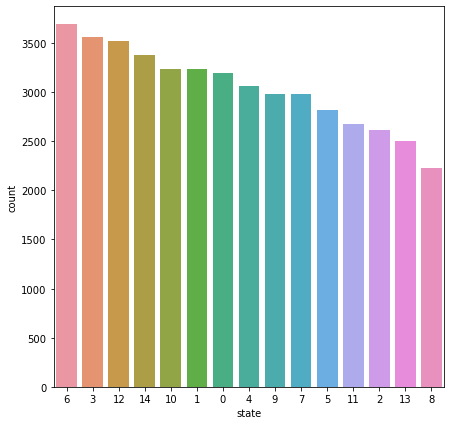

In [406]:
plt.figure(figsize=(7,7))
sbn.countplot(x='state', data=res, order=res.state.value_counts().index)
plt.show()

# Umap representation

In [411]:
reducer = umap.UMAP(n_neighbors=55, min_dist=0.1, n_components=2, metric='euclidean')
embed = reducer.fit_transform(out[state_sel].values)

In [412]:
out = out.assign(z1=embed[:,0], z2=embed[:,1])

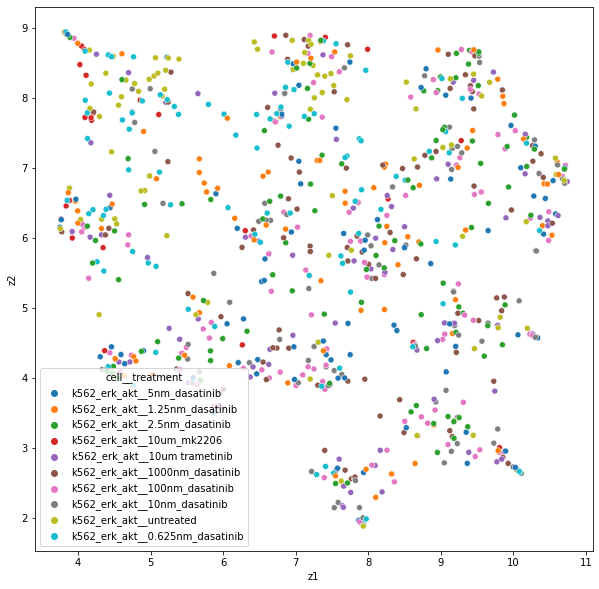

In [413]:
plt.figure(figsize=(10,10))
sbn.scatterplot(x='z1', y='z2', hue='cell__treatment', data=out)
plt.show()

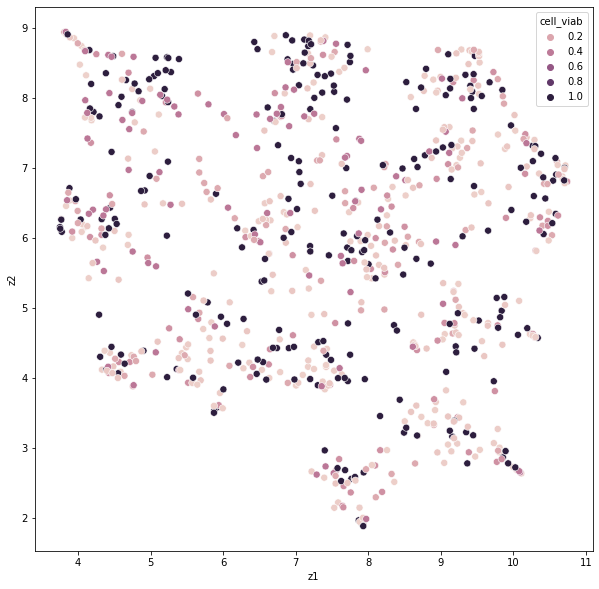

In [414]:
plt.figure(figsize=(10,10))
sbn.scatterplot(x='z1', y='z2', hue='cell_viab', s=50, alpha=1, data=out)
plt.show()

# What does each state look like?

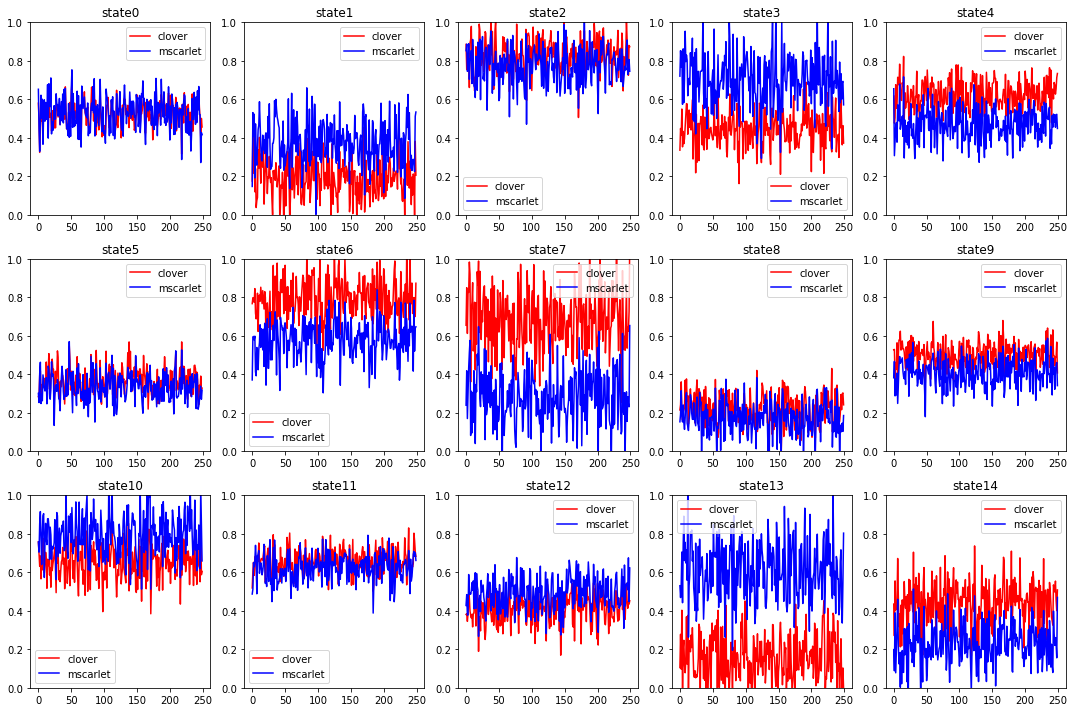

In [415]:
f, axes = plt.subplots(int(nstates/5),5, figsize=(15,10))
for i in range(remodel.n_components): 
    x = np.array([remodel._generate_sample_from_state(i) for x in range(250)])
    axes.flat[i].plot(x[:,0], 'r-', label='clover')
    axes.flat[i].plot(x[:, 1], 'b-', label='mscarlet')
    axes.flat[i].set_title('state' + str(i))
    axes.flat[i].set_ylim((0,1))
    axes.flat[i].legend()
plt.tight_layout()
plt.show()

# State transition matrix 

Which states do they jump between most commonly? 

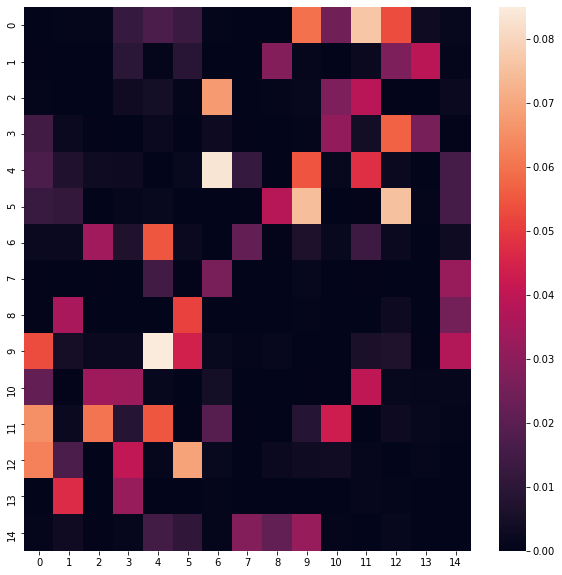

In [416]:
# have to set the diagonal to zero for decent viz (diag is much larger then off diag)
transition_mat = remodel.transmat_.copy()
np.fill_diagonal(transition_mat, 0) #acts *in-place* 

plt.figure(figsize=(10,10))
sbn.heatmap(transition_mat)
plt.show()

75th quantile: 0.01357434434548969


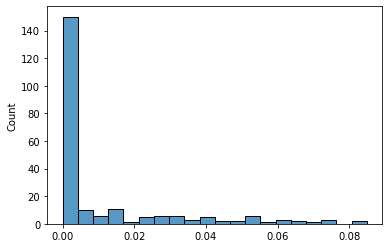

In [417]:
sbn.histplot(transition_mat.flatten())
print('75th quantile:', np.quantile(transition_mat.flatten(),0.75))

In [418]:
def build_and_plot_transition_graph(A, means, title=None, figsize=(12,5), compareto=None, threshold=0.5): 
    
    np.fill_diagonal(A, 0) #acts *in-place* 
    np.fill_diagonal(compareto, 0)
    
    compare_diff = A-compareto
    
    # set small values to zero - want sparse graph 
    A[A < np.quantile(A.flatten(), threshold)] = 0 

    G = nx.DiGraph( A )
    
    pos = {i:x for i,x in enumerate(means)}

    edges = G.edges()
    
    weights = np.array([G[u][v]['weight'] for u,v in edges])
    scaled_weights = weights * 1.0/weights.max()

    f, axes = plt.subplots(1,2, figsize=figsize)
    nx.draw_networkx(G, 
                     pos=pos,
                     arrows=True, 
                     **{'node_color':'red',
                     'node_size': 1000,
                     'width': scaled_weights,
                     'arrowstyle': '->',
                     'arrowsize': 35}, 
                      ax=axes[0])
    
    if compareto is not None: 
        sbn.heatmap(compare_diff, ax=axes[1])

    plt.title(title)
    plt.show()
    
    return G

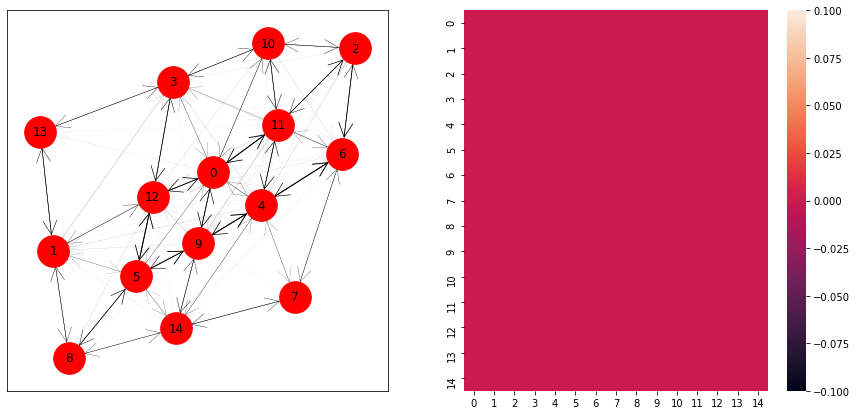

In [420]:
G = build_and_plot_transition_graph(A=remodel.transmat_.copy(), means=remodel.means_, compareto=remodel.transmat_.copy(), figsize=(15,7))

In [421]:
# can we find common loops within this? the positional movement here may indicate specific behavior 

# State Co-variance matrix 

I was curious if any states had co-variance (off diagonal terms - which might indicate correlation between pathway activity)

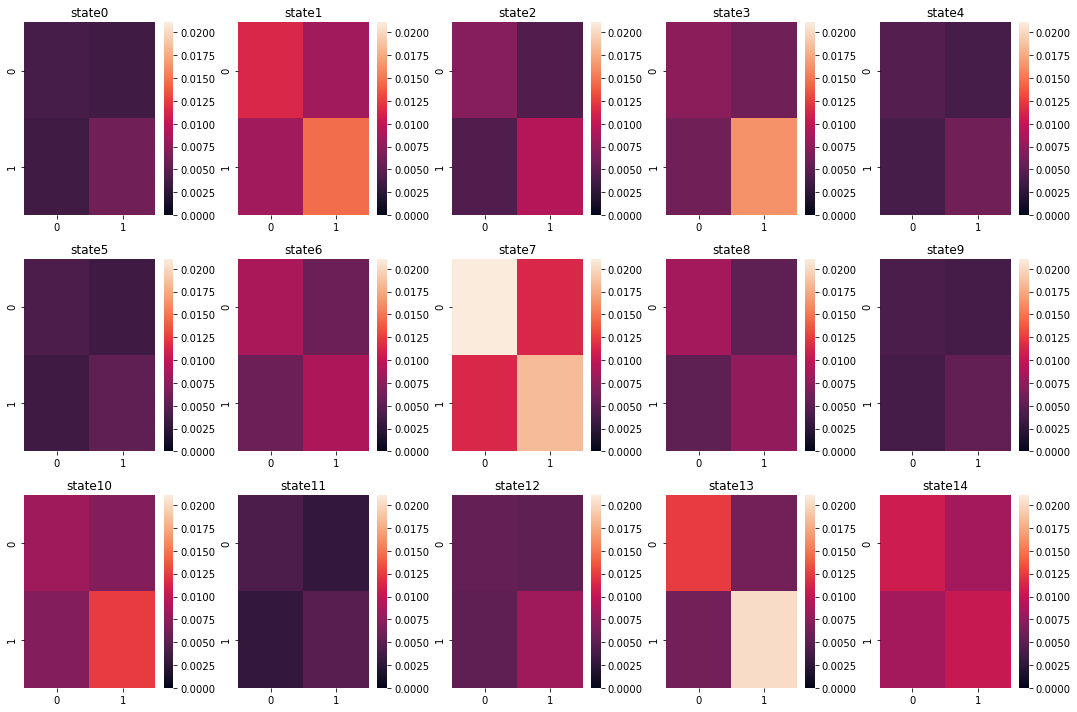

In [422]:
remodel.covars_

f, axes = plt.subplots(int(nstates/5),5, figsize=(15,10))
for i in range(len(axes.flatten())): 
    x = remodel.covars_[i, :, :]
    sbn.heatmap(x, ax=axes.flat[i], vmin=0, vmax=max(remodel.covars_.flatten()))
    axes.flat[i].set_title('state' + str(i))
plt.tight_layout()
plt.show()

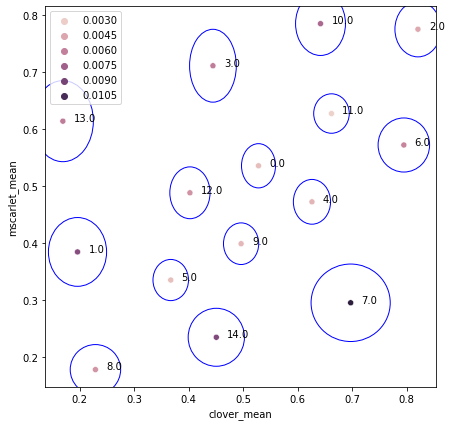

In [423]:
## TODO: add arrow sizes with thickness mediated by transition probabilities. 
## TODO: look at label specific transition probabilities/rates - does this change significnatly??? e.g. do they have different path changes? 


df = pd.DataFrame(remodel.means_, columns=['clover_mean', 'mscarlet_mean']).assign(state=range(remodel.means_.shape[0]))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
    
def circle_point(x, y, var_x, var_y, ax):
    a = pd.concat({'x': x, 'y': y, 'var_x': var_x, 'var_y':var_y}, axis=1)
    for i, point in a.iterrows():
        elps = Ellipse((point.x, point.y), point.var_x**0.5, point.var_y**0.5, edgecolor='b',facecolor='none')
        ax.add_artist(elps)
        

plt.figure(figsize=(7,7))
sbn.scatterplot(x='clover_mean', y='mscarlet_mean', hue=remodel.covars_[:,0, 1], data=df)       
label_point(df.clover_mean, df.mscarlet_mean, df.state, plt.gca())
circle_point(df.clover_mean, df.mscarlet_mean, pd.Series(remodel.covars_[:,0, 0]), pd.Series(remodel.covars_[:,1, 1]), plt.gca())
plt.show()

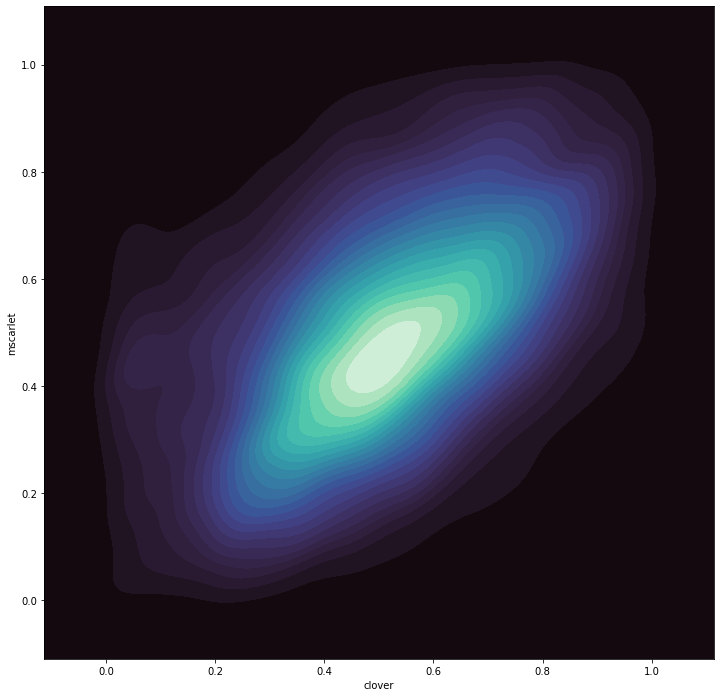

In [34]:
# does this orginization correllate to density of time series points? 
plt.figure(figsize=(12,12))
df2 = pd.DataFrame(X, columns=['clover', 'mscarlet'])
sbn.kdeplot(
    data=df2, x="clover", y="mscarlet",
    fill=True, thresh=0, levels=25, cmap="mako",
)
plt.show()

# Train HMM within each treatment group then compare HMM transition matrices 

In [424]:
data.head()

,track_index,erk_time(h)=0.0,erk_time(h)=0.2,erk_time(h)=0.5,erk_time(h)=0.8,erk_time(h)=1.0,erk_time(h)=1.2,erk_time(h)=1.5,erk_time(h)=1.8,erk_time(h)=2.0,...,akt_time(h)=13.5,akt_time(h)=13.8,akt_site,akt_median,conc_nm,inhibitor,cell_line,control_OD,optical_density,cell_viab
0,78_1000101697_k562_erk_akt__untreated,0.666206,0.583154,0.464076,0.401721,0.574265,0.628919,0.533323,0.639510,0.808772,...,0.498220,0.523217,78,0.496346,0.0,none,k562,NaN,NaN,1.0
1,77_1000098381_k562_erk_akt__untreated,0.646522,0.419623,0.636420,0.608784,0.593370,0.594475,0.764531,0.781966,0.703256,...,0.630918,0.623906,77,0.503596,0.0,none,k562,NaN,NaN,1.0
2,4_1000007026_k562_erk_akt__untreated,0.731499,0.644271,0.565533,0.405811,0.538459,0.716891,0.771548,0.708265,0.789968,...,0.835404,0.626950,4,0.642910,0.0,none,k562,NaN,NaN,1.0
3,2_1000002957_k562_erk_akt__untreated,0.860727,0.690160,0.633814,0.886553,0.915976,0.856283,0.759563,0.927312,0.948254,...,0.749850,0.384942,2,0.541348,0.0,none,k562,NaN,NaN,1.0
4,82_1000111191_k562_erk_akt__untreated,0.547424,0.521789,0.448863,0.573173,0.504300,0.525133,0.493384,0.638652,0.621023,...,0.684539,0.720796,82,0.609912,0.0,none,k562,NaN,NaN,1.0


In [425]:
HMMs = {}
for treatment in data.cell__treatment.unique(): 
    print('fitting:', treatment)
    temp = data[data.cell__treatment == treatment]
    _x, _lens = form_data(temp)
    HMMs[treatment] = get_HMM(_x, _lens, nstates, niter=10, means=remodel.means_)
    

fitting: k562_erk_akt__untreated
shape: (4480, 2)
model converged: True
fitting: k562_erk_akt__0.625nm_dasatinib
shape: (5096, 2)
model converged: True
fitting: k562_erk_akt__1.25nm_dasatinib
shape: (4648, 2)
model converged: True
fitting: k562_erk_akt__2.5nm_dasatinib
shape: (5544, 2)
model converged: True
fitting: k562_erk_akt__5nm_dasatinib
shape: (4536, 2)
model converged: True
fitting: k562_erk_akt__10nm_dasatinib
shape: (4256, 2)
model converged: True
fitting: k562_erk_akt__100nm_dasatinib
shape: (5768, 2)
model converged: True
fitting: k562_erk_akt__1000nm_dasatinib
shape: (5096, 2)
model converged: True
fitting: k562_erk_akt__10um trametinib
shape: (4760, 2)
model converged: True
fitting: k562_erk_akt__10um_mk2206
shape: (1512, 2)
model converged: True


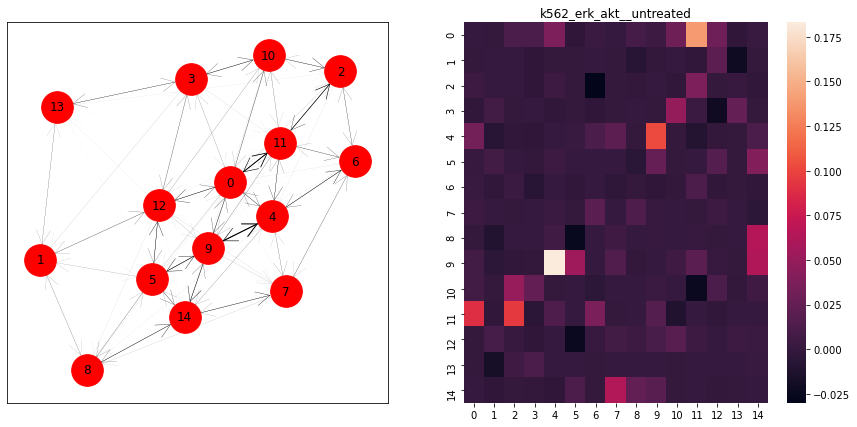

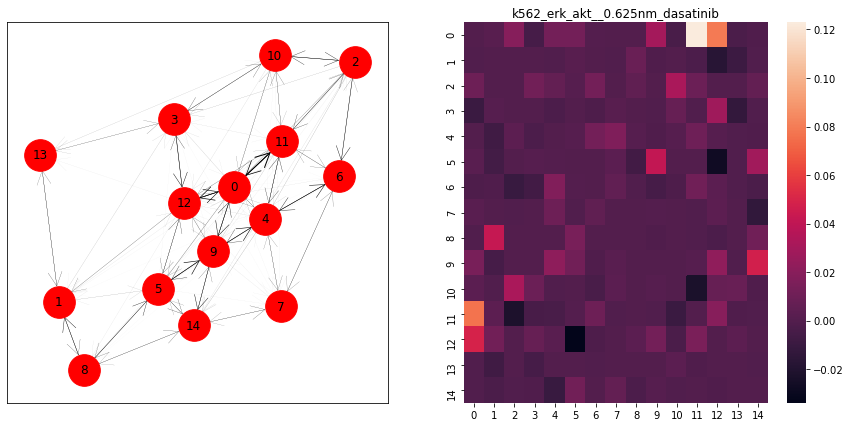

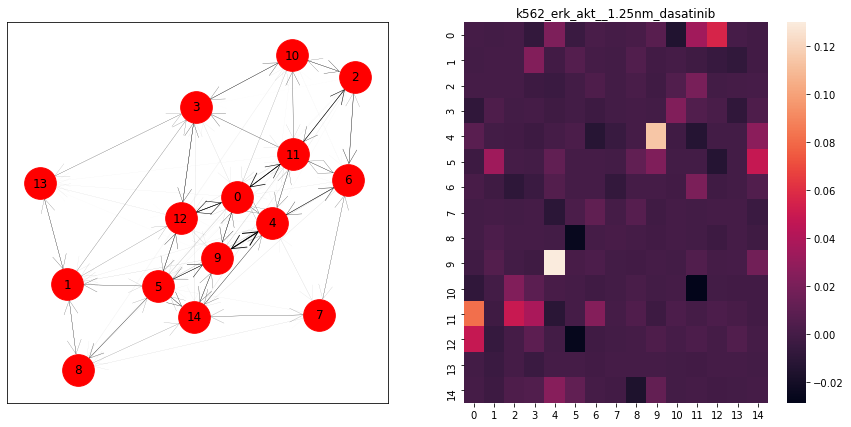

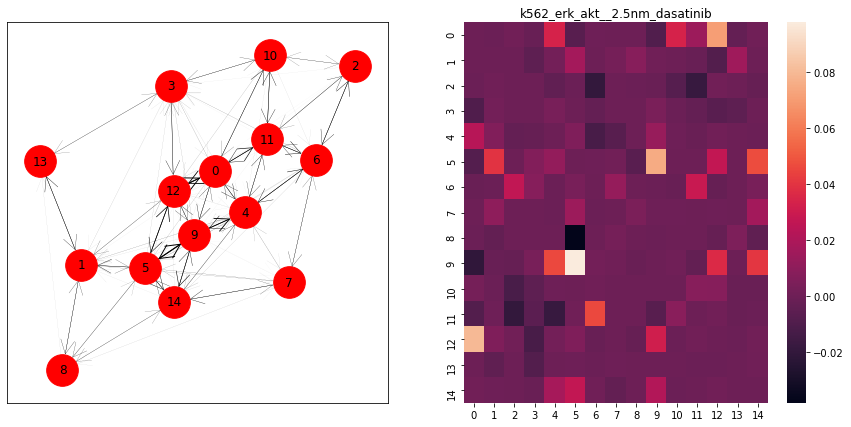

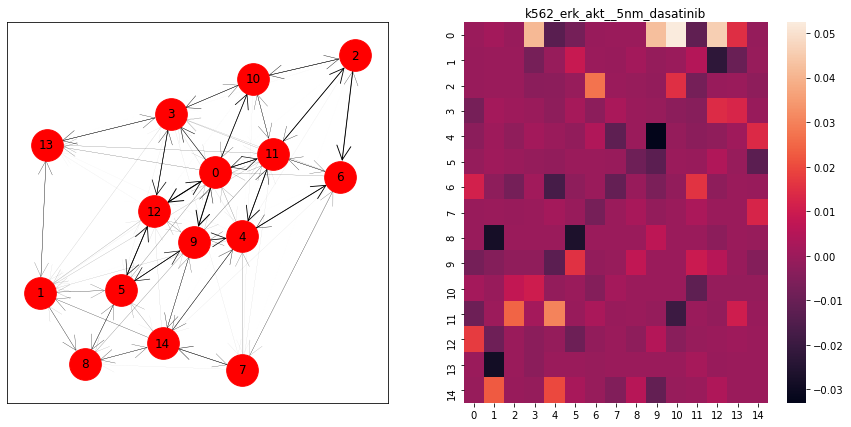

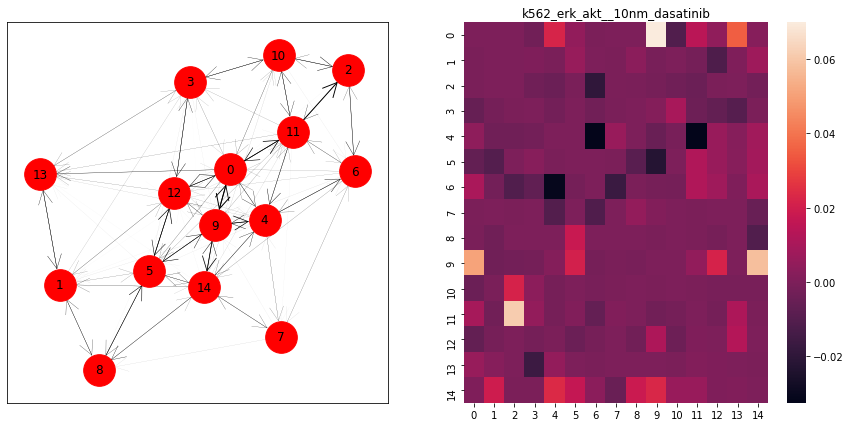

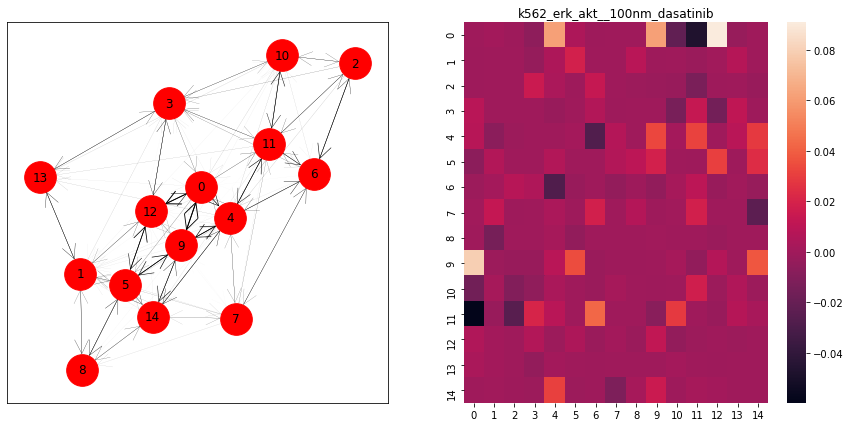

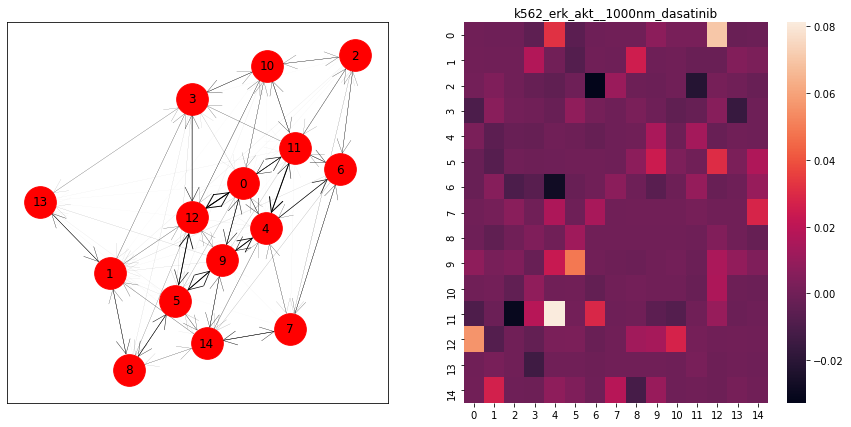

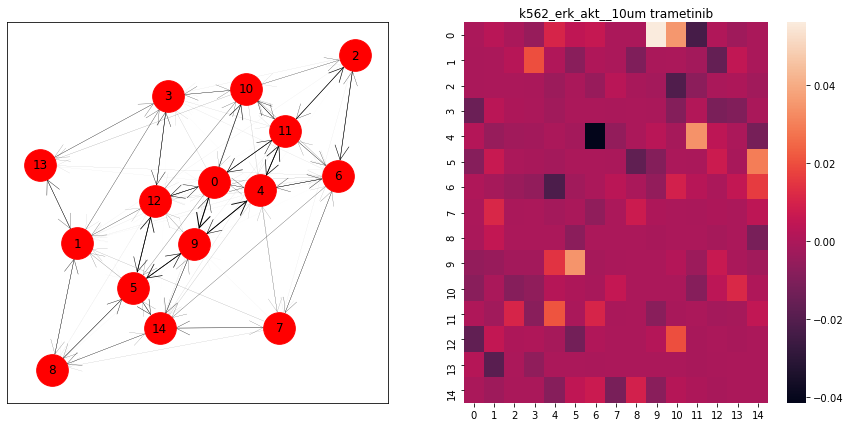

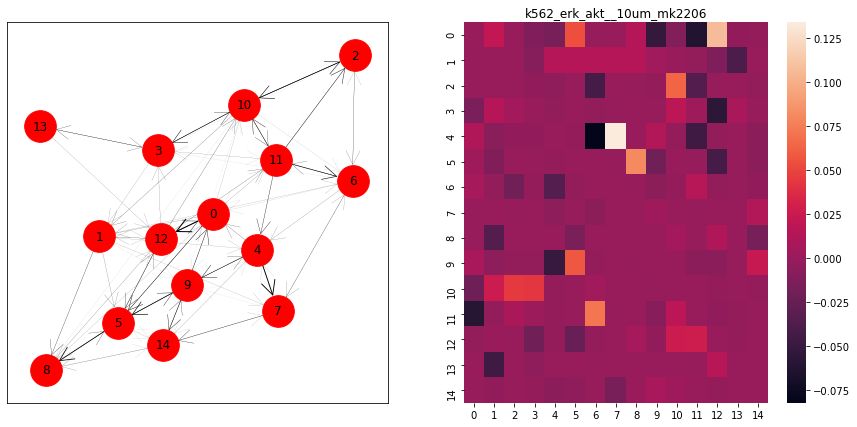

In [427]:
for treatment in HMMs: 
    _ = build_and_plot_transition_graph(A=HMMs[treatment].transmat_.copy(), means=HMMs[treatment].means_.copy(), title=treatment, figsize=(15,7), compareto=remodel.transmat_.copy())